In [9]:
import sys, os
sys.path.append(os.pardir)

In [10]:
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from future.utils import iteritems
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
import pandas as pd
df = pd.read_csv('naver_headline.csv', encoding='utf-8')
df.head()

,title,month
0,"北김정은 ""조선반도 항구적 평화지대로 만들려는 확고한 의지""(종합…",1
1,"문대통령, 의인 6명과 75분간 남산 등반 '새해맞이'",1
2,김정은 파격 변신… 원고 들고 집무실 소파에 앉아 토크쇼 연출,1
3,"軍, 日 레이더 영상 공개에 맞대응…'반박 영상' 제작",1
4,"김정은 신년사, 정상국가 이미지 강조…김여정·조용원 실세 재확인",1


In [12]:
df['title'].isnull().values.any()

False

In [13]:
def change_string(x):
    return x.replace('靑','청와대').replace('軍','군대').replace('北','북한').replace('美','미국').replace('日','일본').replace('韓', '한국').replace('與', '여당').replace('野', '야당').replace('中', '중국')

In [14]:
df['title'] = df['title'].map(lambda x : change_string(x))

In [15]:
headline = []
headline.extend(list(df.title.values))
headline[:5]

['북한김정은 "조선반도 항구적 평화지대로 만들려는 확고한 의지"(종합…',
 "문대통령, 의인 6명과 75분간 남산 등반 '새해맞이'",
 '김정은 파격 변신… 원고 들고 집무실 소파에 앉아 토크쇼 연출',
 "군대, 일본 레이더 영상 공개에 맞대응…'반박 영상' 제작",
 '김정은 신년사, 정상국가 이미지 강조…김여정·조용원 실세 재확인']

In [16]:
headline = [n for n in headline if n != ""]
len(headline)

1135

In [17]:
from string import punctuation
import re

def clean_text(text):
#     cleaned_text = [''.join(c for c in text).lower()]
#     cleaned_text = re.sub('[^가-힣a-zA-Z文 ]', '', text)
    cleaned_text = re.sub('[0-9]', ' ', text)
    cleaned_text = re.sub('[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"\'\·]',
                          ' ', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    return cleaned_text

In [18]:
text = [clean_text(x) for x in headline]
text = pd.DataFrame(text, columns=['headline'])
# text.to_csv('beforenoun.csv', encoding='utf-8')

In [19]:
from konlpy.tag import Komoran
komoran = Komoran(userdic='./user_dic.txt')
text['headline'] = text.apply(lambda row: komoran.nouns(row['headline']), axis=1)
text.head()
# text.to_csv('noun.csv', encoding='utf-8')

C:\ProgramData\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


,headline
0,"[북한, 김정은, 조선, 반도, 항구, 평화, 지대, 의지, 종합]"
1,"[문, 대통령, 의인, 명, 분간, 남산, 등반, 새해맞이]"
2,"[김정은, 파격, 변신, 원고, 집무실, 소파, 토크, 쇼, 연출]"
3,"[군대, 일본, 레이더, 영상, 공개, 맞대응, 반박, 영상, 제작]"
4,"[김정은, 신년사, 정상, 국가, 이미지, 강조, 김여정, 조용원, 실세, 재확인]"


In [20]:
stop_words = ['신문', '종합', '단독', '상보', '속보', '것', '뉴스', '내일']
text['headline'] = text['headline'].apply(lambda x: [word for word in x
                                                    if word not in stop_words 
                                                    ])
text.head()

,headline
0,"[북한, 김정은, 조선, 반도, 항구, 평화, 지대, 의지]"
1,"[문, 대통령, 의인, 명, 분간, 남산, 등반, 새해맞이]"
2,"[김정은, 파격, 변신, 원고, 집무실, 소파, 토크, 쇼, 연출]"
3,"[군대, 일본, 레이더, 영상, 공개, 맞대응, 반박, 영상, 제작]"
4,"[김정은, 신년사, 정상, 국가, 이미지, 강조, 김여정, 조용원, 실세, 재확인]"


In [21]:
tokenized_doc = text['headline'].apply(lambda x: [word for word in x if len(word) >1])
tokenized_doc.head()

0                 [북한, 김정은, 조선, 반도, 항구, 평화, 지대, 의지]
1                       [대통령, 의인, 분간, 남산, 등반, 새해맞이]
2                [김정은, 파격, 변신, 원고, 집무실, 소파, 토크, 연출]
3            [군대, 일본, 레이더, 영상, 공개, 맞대응, 반박, 영상, 제작]
4    [김정은, 신년사, 정상, 국가, 이미지, 강조, 김여정, 조용원, 실세, 재확인]
Name: headline, dtype: object

In [22]:
# 역토큰화

documents = []
for i in range(len(text)):
    t = ' '.join(tokenized_doc[i])
    documents.append(t)
    
documents[:5]

['북한 김정은 조선 반도 항구 평화 지대 의지',
 '대통령 의인 분간 남산 등반 새해맞이',
 '김정은 파격 변신 원고 집무실 소파 토크 연출',
 '군대 일본 레이더 영상 공개 맞대응 반박 영상 제작',
 '김정은 신년사 정상 국가 이미지 강조 김여정 조용원 실세 재확인']

In [23]:
# 단어 인덱싱 및 빈도세기

as_one = ''
for document in documents:
    as_one = as_one + ' ' +document
words = as_one.split()
words[:10]

['북한', '김정은', '조선', '반도', '항구', '평화', '지대', '의지', '대통령', '의인']

In [24]:
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse = True)
word2idx = {word.encode("utf8").decode("utf8"): ii for ii, word in enumerate(vocab,1)}
idx2word = {ii: word for ii, word in enumerate(vocab)}

In [25]:
# Term Frequency

V = len(word2idx)
N = len(documents)

tf = CountVectorizer()
tf.fit_transform(documents)

<1135x2755 sparse matrix of type '<class 'numpy.int64'>'
	with 7190 stored elements in Compressed Sparse Row format>

In [26]:
# TF-IDF

tfidf = TfidfVectorizer(max_features=100, max_df=0.95, min_df=0)
#generate tf-idf term-document matrix
A_tfidf_sp = tfidf.fit_transform(documents)

#tf-idf dictionary  
tfidf_dict = tfidf.get_feature_names()

data_array = A_tfidf_sp.toarray()
data = pd.DataFrame(data_array, columns=tfidf_dict)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.002s...
[t-SNE] Computed neighbors for 100 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.993400
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.229294
[t-SNE] KL divergence after 2050 iterations: 0.811609


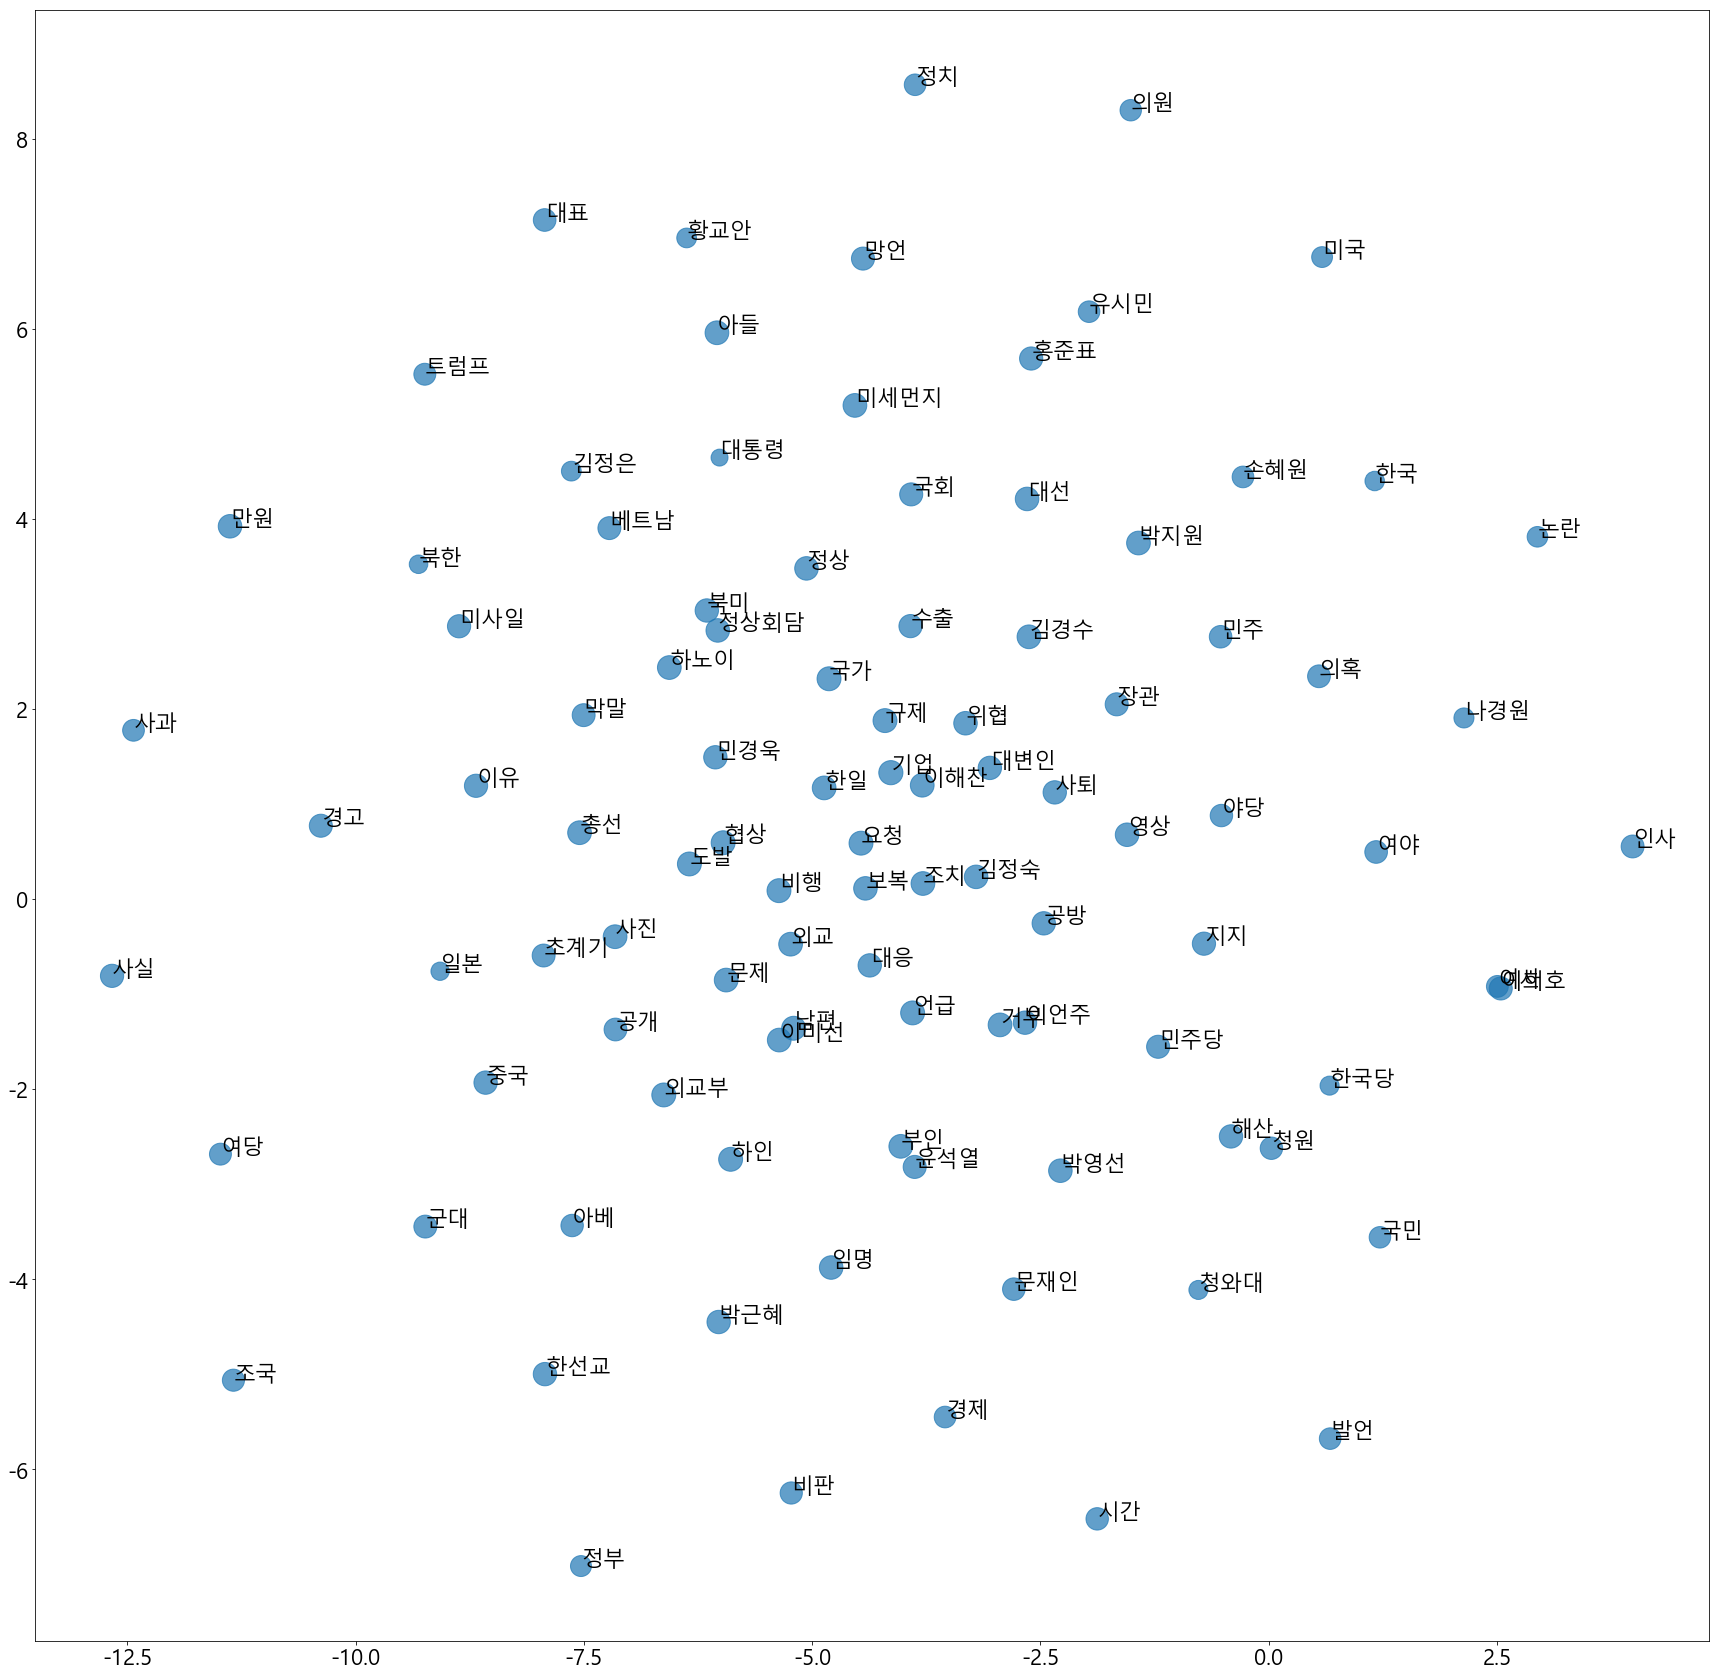

In [27]:
# TF-IDF score Top 100 단어 시각화

tsne = TSNE(n_components=2, n_iter=10000, verbose=1)
Z = tsne.fit_transform(data_array.T)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

import matplotlib as mpl
mpl.rcParams.update({'font.size': 22})

plt.figure(figsize=(30,30))
size = tfidf.idf_ * 100
plt.scatter(Z[:,0], Z[:,1], s=size, alpha=.7)
for x, y, name in zip(Z[:,0], Z[:,1], tfidf_dict):
    plt.text(x, y, name)
plt.show()